### 抵抗过拟合的方法
- 常见的抵抗过拟合的方法有:增大数据集，提前停止(Early-Stopping)，Dropout，正则化等，标签平滑(label Smoothing)等。

#### 数据增强
- 数据增强就是增加数据量，数据对于机器学习或者深度学习来说非常重要，有时候拥有更 多的数据胜过拥有一个好的模型。一般来说更多的数据参与训练，训练得到的模型就更好。如 果数据太少，而我们构建的神经网络又太复杂的话就比较容易产生过拟合的现象。
- 在图像领域，数据增加的手段经常被使用，我们可以通过对图片进行一些调整来生成更多图片，常用的手段如下:
    - 旋转 | 反射变换(Rotation/reflection): 随机旋转图像一定角度; 改变图像内 容的朝向。
    - 翻转变换(flip): 沿着水平或者垂直方向翻转图像。
    - 缩放变换(zoom): 按照一定的比例放大或者缩小图像。
    - 平移变换(shift): 在图像平面上对图像以一定方式进行平移。
    - 尺度变换(scale): 对图像按照指定的尺度因子, 进行放大或缩小。
    - 颜色变换(color): 对训练集图像的颜色进行一些有规律的调整。
- Tensorflow 中有封装好的程序可以非常方便的帮助我们实现图像数据增强的功能

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

datagen = ImageDataGenerator( 
                rotation_range = 40, # 随机旋转度数 
                width_shift_range = 0.2,# 随机水平平移 
                height_shift_range = 0.2,# 随机竖直平移
                rescale = 1/255,#数据归一化
                shear_range = 30,#随机错切变化
                zoom_range = 0.2, #随机放大
                horizontal_flip=True, #水平翻转 
                brightness_range = (0.7,1.3), # 亮度变化 
                fill_mode = 'nearest', # 填充方式
)
# 载入图片
img = load_img('./bobo.jpg')
# 把图片变成3维array
x = img_to_array(img)

# keras要求我们需要把数据变成 4 维，才可以做数据增强
x = np.expand_dims(x,0)

#生成20张图片
i=0
# 生成的图片都保存在 temp 文件夹中，文件名前缀为 new_cat,图片格式为 jpeg
for batch in datagen.flow(x, batch_size=1, save_to_dir='temp', save_prefix='new_cat', save_format='jpeg'):
    i += 1
    if i==20:
        break

#### 提前停止训练
- 在训练模型的时候，我们往往会设置一个比较大的迭代次数 n。一般的做法是记录到目前 为止最好的测试集准确率 p，之后连续 m 个周期没有超过最佳测试集准确率 p 时，则可以认 为 p 不再提高了，此时便可以提前停止迭代(Early-Stopping)。

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# 载入数据集手写数字
mnist = tf.keras.datasets.mnist
#数据载入的时候就已经划分好训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 对训练集和测试集的数据进行归一化处理，有助于提升模型训练速度 
x_train, x_test = x_train / 255.0, x_test / 255.0

# 把训练集和测试集的标签转为独热编码
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10) 
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

# 模型定义
# 先用 Flatten 把数据从 3 维变成 2 维，(60000,28,28)->(60000,784)
# 设置输入数据形状 input_shape 不需要包含数据的数量，(28,28)即可
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax') ])

# sgd 定义随机梯度下降法优化器
# loss='mse'定义均方差代价函数
# metrics=['accuracy']模型在训练的过程中同时计算准确率 
sgd = SGD(0.5)
model.compile(optimizer=sgd,loss='mse', metrics=['accuracy'])

# monitor='val_accuracy',监控验证集准确率
# patience=5,连续 5 个周期没有超过最高的 val_accuracy 值，则提前停止训练
# verbose=1，停止训练时提示 early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# 周期大小为 100(把所有训练集数据训练一次称为训练一个周期) 
# 批次大小为 32(每次训练模型传入 32 个数据进行训练)
# validation_data 设置验证集数据
# callbacks=[early_stopping]用于指定在每个 epoch 或 batch 开始和结 束的时候进行哪种特定操作
model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32, 
    validation_data=(x_test,y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0272 - accuracy: 0.8385 - val_loss: 0.0166 - val_accuracy: 0.9007
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0164 - accuracy: 0.8996 - val_loss: 0.0145 - val_accuracy: 0.9106
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0149 - accuracy: 0.9073 - val_loss: 0.0136 - val_accuracy: 0.9154
Epoch 4/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0141 - accuracy: 0.9119 - val_loss: 0.0130 - val_accuracy: 0.9184
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0135 - accuracy: 0.9149 - val_loss: 0.0127 - val_accuracy: 0.9193
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0132 - accuracy: 0.9167 - val_loss: 0.0124 - val_accuracy: 0.9215
Epoch 7/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0128 - accuracy: 0.9187 - val_loss: 0.0123 - val_ac

#### Dropout
- Dropout 也是一种用于抵抗过拟合的技术，它试图改变网络本身来对网络进行优化。我 们先来了解一下它的工作机制，当我们训练一个普通的神经网络时，网络的结构可能如图1所示。
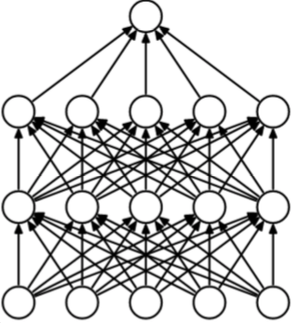

- Dropout 通常是在神经网络隐藏层的部分使用，使用的时候会临时关闭掉一部分的神经元，我们可以通过一个参数来控制神经元被关闭的概率，网络结构如图2所示。
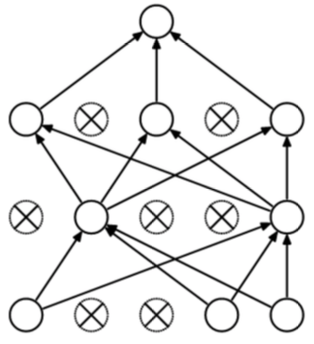

- 具体实现流程如下：
    - 1. 在模型训练阶段我们可以先给 Dropout 参数设置一个值，例如 0.4。意思是大约 60%的神经元是工作的，大约40%神经元是不工作的。
    - 2. 给需要进行Dropout的神经网络层的每一个神经元生成一个0-1的随机数(一般是对隐藏层进行 Dropout)。如果神经元的随机数小于 0.6，那么该神经元就设置为 工作状态的;如果神经元的随机数大于等于 0.6，那么该神经元就设置为不工作的，不 工作状态的意思就是不参与计算和训练，可以当这个神经元不存在。
    - 3. 设置好一部分神经元工作一部分神经元不工作之后，我们会发现神经网络的输出值会发现变化，如图1中，如果隐藏层有一半不工作，那么网络输出值就会比原来的值要小，因为计算 WX+b 时，如果 W 矩阵中，有一部分的值变成0（则表示神经元消失，不起作用），那么最后的计算结果肯定会变小（累和）。所以为了使用 Dropout 的网络层神经元信号的总和不会发生太大的变化，对于工作的神经元的输出信号还需要除以0.4（增大最终的预测值）。
    - 4. 训练阶段重复1-3步骤，每一次都随机选择部分的神经元参与训练。 
    - 5. 在测试阶段所有的神经元都参与计算。

- 注意：Dropout 比较适合应用于只有少量数据但是需要训练复杂模型的场景，这类场景在图像 领域比较常见，所以 Dropout 经常用于图像领域。

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

# 载入数据集
mnist = tf.keras.datasets.mnist
# 载入训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对训练集和测试集的数据进行归一化处理，有助于提升模型训练速度 
x_train, x_test = x_train / 255.0, x_test / 255.0
# 把训练集和测试集的标签转为独热编码
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

# 模型定义，model1 使用 Dropout
# Dropout(0.4)表示隐藏层 40%神经元不工作 
model1 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh'), 
    Dropout(0.4), 
    Dense(units=100,activation='tanh'), 
    Dropout(0.4), 
    Dense(units=10,activation='softmax') ])

# 在定义一个一模一样的模型用于对比测试，model2 不使用 Dropout 
# Dropout(0)表示隐藏层所有神经元都工作，相当于没有 Dropout 
model2 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh'), 
    Dropout(0), 
    Dense(units=100,activation='tanh'), 
    Dropout(0), 
    Dense(units=10,activation='softmax') ])

sgd = SGD(0.2)
model1.compile(
            optimizer=sgd,
            #交叉熵损失函数
            loss='categorical_crossentropy',
            metrics=['accuracy']) 
model2.compile(
            optimizer=sgd,
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# 周期大小为 30(把所有训练集数据训练一次称为训练一个周期)
epochs = 30
# 批次大小为 32(每次训练模型传入 32 个数据进行训练)
batch_size=32
# 先训练 model1
history1 = model1.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))
# 再训练 model2
history2 = model2.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4181 - accuracy: 0.8734 - val_loss: 0.2171 - val_accuracy: 0.9348
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2796 - accuracy: 0.9172 - val_loss: 0.1653 - val_accuracy: 0.9502
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2395 - accuracy: 0.9299 - val_loss: 0.1414 - val_accuracy: 0.9555
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2135 - accuracy: 0.9362 - val_loss: 0.1248 - val_accuracy: 0.9616
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1966 - accuracy: 0.9420 - val_loss: 0.1263 - val_accuracy: 0.9622
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1858 - accuracy: 0.9448 - val_loss: 0.1198 - val_accuracy: 0.9650
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1723 - accuracy: 0.9490 - val_loss: 0.1126 - val_accuracy:

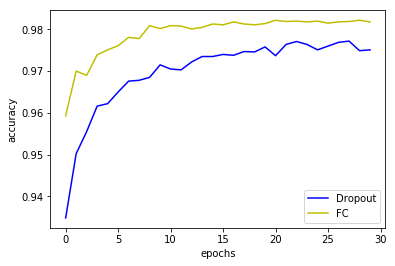

In [16]:
# 画出 model1 验证集准确率曲线图 
plt.plot(np.arange(epochs),history1.history['val_accuracy'],c='b',label='Dropout') 
# 画出 model2 验证集准确率曲线图 
plt.plot(np.arange(epochs),history2.history['val_accuracy'],c='y',label='FC') 
#图例
plt.legend()
# x 坐标描述
plt.xlabel('epochs')
# y 坐标描述 
plt.ylabel('accuracy') 
# 显示图像 
plt.show()

####  正则化
- 正则化也叫作规范化，通常用得比较多的方式是 L1 正则化和 L2 正则化。L1 和 L2 正则 化的使用实际上就是在普通的代价函数(例如均方差代价函数)后面加上一个正则项。

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l1,l2

# 载入数据集
mnist = tf.keras.datasets.mnist
# 载入训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对训练集和测试集的数据进行归一化处理，有助于提升模型训练速度 
x_train, x_test = x_train / 255.0, x_test / 255.0
# 把训练集和测试集的标签转为独热编码
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

# kernel_regularizer指定使用正则化的操作 
model1 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh',kernel_regularizer=l2(0.0003)),
    Dense(units=100,activation='tanh',kernel_regularizer=l2(0.0003)), 
    Dense(units=10,activation='softmax',kernel_regularizer=l2(0.0003))
])
#在定义一个一模一样的模型用于对比测试，model2 不使用正则化 
model2 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh'), 
    Dense(units=100,activation='tanh'), 
    Dense(units=10,activation='softmax')
])

sgd = SGD(0.2)
model1.compile(
            optimizer=sgd,
            #交叉熵损失函数
            loss='categorical_crossentropy',
            metrics=['accuracy']) 
model2.compile(
            optimizer=sgd,
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# 周期大小为 30(把所有训练集数据训练一次称为训练一个周期)
epochs = 30
# 批次大小为 32(每次训练模型传入 32 个数据进行训练)
batch_size=32
# 先训练 model1
history1 = model1.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))
# 再训练 model2
history2 = model2.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4044 - accuracy: 0.9199 - val_loss: 0.2888 - val_accuracy: 0.9526
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2609 - accuracy: 0.9595 - val_loss: 0.2391 - val_accuracy: 0.9655
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2179 - accuracy: 0.9685 - val_loss: 0.2137 - val_accuracy: 0.9681
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1937 - accuracy: 0.9728 - val_loss: 0.1863 - val_accuracy: 0.9737
Epoch 5/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1775 - accuracy: 0.9758 - val_loss: 0.1771 - val_accuracy: 0.9736
Epoch 6/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1684 - accuracy: 0.9768 - val_loss: 0.1813 - val_accuracy: 0.9723
Epoch 7/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1613 - accuracy: 0.9787 - val_loss: 0.1831 - val_accuracy:

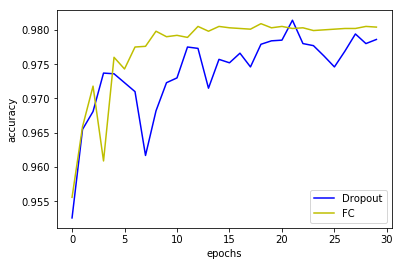

In [22]:
# 画出 model1 验证集准确率曲线图 
plt.plot(np.arange(epochs),history1.history['val_accuracy'],c='b',label='Dropout') 
# 画出 model2 验证集准确率曲线图 
plt.plot(np.arange(epochs),history2.history['val_accuracy'],c='y',label='FC') 
#图例
plt.legend()
# x 坐标描述
plt.xlabel('epochs')
# y 坐标描述 
plt.ylabel('accuracy') 
# 显示图像 
plt.show()

- 在神经网络结构比较复杂，训练数 据量比较少的时候，使用正则化效果会比较好。如果网络不算太复杂的话，任务比较简单的 时候，使用正则化可能准确率反而会下降。对于 Dropout 来说也有类似的情况。所以 Dropout 和正则化需要根据实际使用情况的好坏来决定是否使用。

#### 标签平滑
- 标签平滑(label smoothing)也称为标签平滑正则化(label-smoothing regularization)， 简称 LSR。从名字就可以看出标签平滑也是一种正则化策略。
- 我们在做分类模型的时候通常会把标签变成独热编码(one-hot)，但是变成独热编码的 标签在模型训练时会使得模型变得“极度自信”，容易产生过拟合。独热编码(one-hot)可能 存在的问题我给大家举个例子大家就容易理解了，如图1所示就是一个数字。
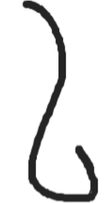
- 这个数字你能说它 100%就是 6 吗，不一定吧，它也有点像 2，说不定还是 1 或者 7 只不过手滑了。所以让模型非常自信的认为图中的数字就是6，用独热编码(0,0,0,0,0,0,1,0,0,0)表示不一定是合适的（因为有几率是别的数字）。可能把它的标签改成(0,0.02,0.2,0.01,0.01,0.01,0.7,0.03,0.01,0.01)会比较好一点。
- 在 MNIST 数据集里面实际上确实有一些数字会写得比较奇怪，让人也很难分辨，其它数 据集也会有类似的问题，所以让模型“过度自信”就不一定是好事了。

- 标签平滑的处理方式
    - 给大家举一个具体的例子
        - 我们需要设置一个平滑系数，比如 0.1，假设一共有 10 个种类。
        - 某个数据的真实标签为:
            - (0,0,0,0,0,1,0,0,0,0)
        - 经过标签平滑处理以后的标签为: 
            - (0.01,0.01,0.01,0.01,0.01,0.91,0.01,0.01,0.01,0.01)
        - 也就类似于下面程序，label_smoothing 为平滑系数:
        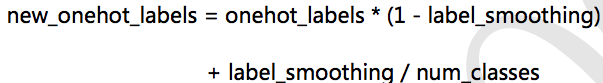

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
# 载入数据集
mnist = tf.keras.datasets.mnist
# 载入训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对训练集和测试集的数据进行归一化处理，有助于提升模型训练速度 
x_train, x_test = x_train / 255.0, x_test / 255.0
# 把训练集和测试集的标签转为独热编码
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

# 模型定义，model1 不用 label smoothing
model1 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh'),
    Dense(units=100,activation='tanh'), 
    Dense(units=10,activation='softmax')
])
# 在定义一个一模一样的模型用于对比测试，model2 使用 label smoothing
model2 = Sequential([
    Flatten(input_shape=(28, 28)), 
    Dense(units=200,activation='tanh'), 
    Dense(units=100,activation='tanh'), 
    Dense(units=10,activation='softmax')
])

# model1 不用 label smoothing
loss1 = CategoricalCrossentropy(label_smoothing=0)
# model2 使用 label smoothing
loss2 = CategoricalCrossentropy(label_smoothing=0.1)

sgd = SGD(0.2)
model1.compile(
            optimizer=sgd,
            #交叉熵损失函数
            loss=loss1,
            metrics=['accuracy']) 
model2.compile(
            optimizer=sgd,
            loss=loss2, 
            metrics=['accuracy'])

# 周期大小为 30(把所有训练集数据训练一次称为训练一个周期)
epochs = 30
# 批次大小为 32(每次训练模型传入 32 个数据进行训练)
batch_size=32
# 先训练 model1
history1 = model1.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))
# 再训练 model2
history2 = model2.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_test,y_test))

Epoch 1/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2576 - accuracy: 0.9223 - val_loss: 0.1479 - val_accuracy: 0.9571
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1146 - accuracy: 0.9656 - val_loss: 0.0953 - val_accuracy: 0.9691
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0800 - accuracy: 0.9751 - val_loss: 0.0865 - val_accuracy: 0.9712
Epoch 4/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0589 - accuracy: 0.9815 - val_loss: 0.0795 - val_accuracy: 0.9743
Epoch 5/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0817 - val_accuracy: 0.9746
Epoch 6/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0338 - accuracy: 0.9901 - val_loss: 0.0676 - val_accuracy: 0.9781
Epoch 7/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.0686 - val_accuracy:

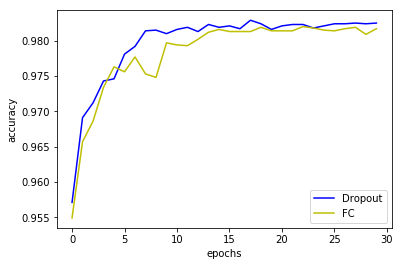

In [24]:
# 画出 model1 验证集准确率曲线图 
plt.plot(np.arange(epochs),history1.history['val_accuracy'],c='b',label='Dropout') 
# 画出 model2 验证集准确率曲线图 
plt.plot(np.arange(epochs),history2.history['val_accuracy'],c='y',label='FC') 
#图例
plt.legend()
# x 坐标描述
plt.xlabel('epochs')
# y 坐标描述 
plt.ylabel('accuracy') 
# 显示图像 
plt.show()